# Overview

This EDA is only done on closing prices of the stock

## Libraries Import

In [28]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

%matplotlib inline

## Autocorrelation and Partial Autocorrelation 

All Partial Autocorrelation (PACF) of listed stock and indeces below showed significant drop in correlation at lag 2. This shows that AR(2) is an appropriate start for modeling selected companies. 

In [45]:
symbols=["SPY", "AAPL", "MSFT", "AMZN", "FB", "GOOGL", "GOOG", "BRK.B", "JNJ", "JPM", "V"] #big 10 symbols to collect
pricetype = "close"
analysis_date_start = "2019-01-01"
analysis_date_end = "2020-02-28"

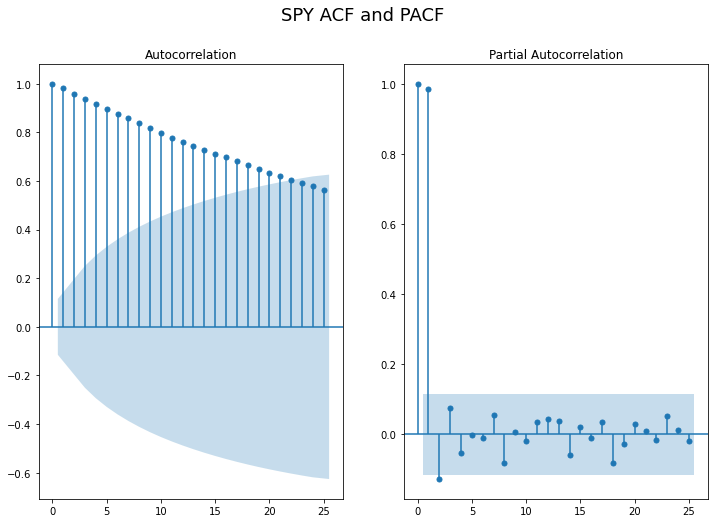

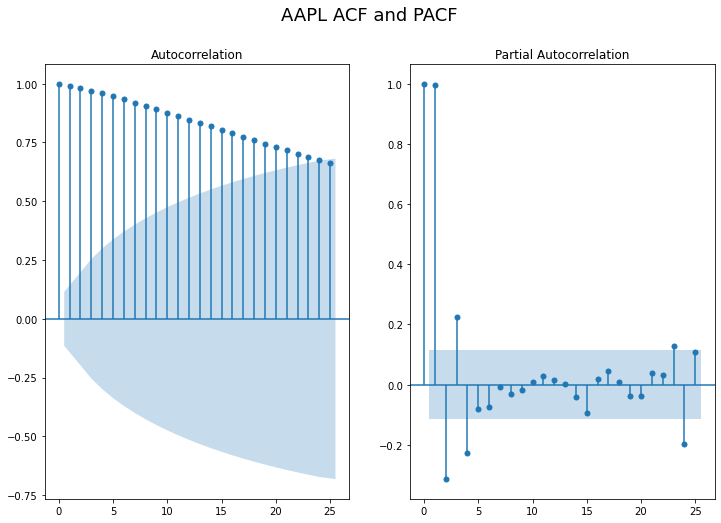

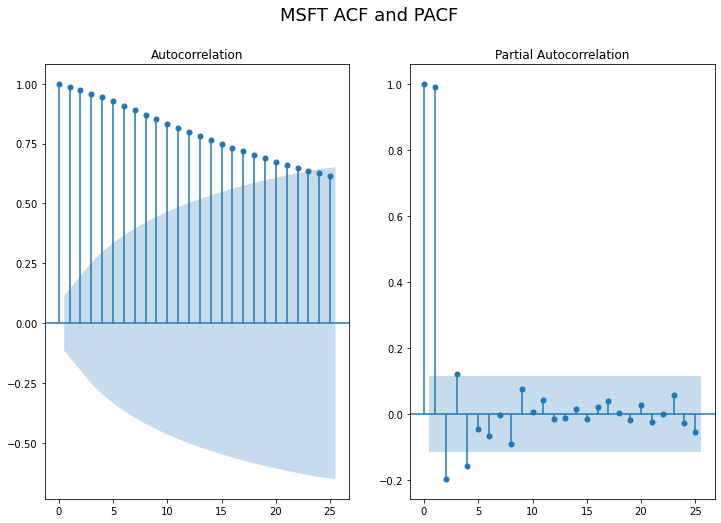

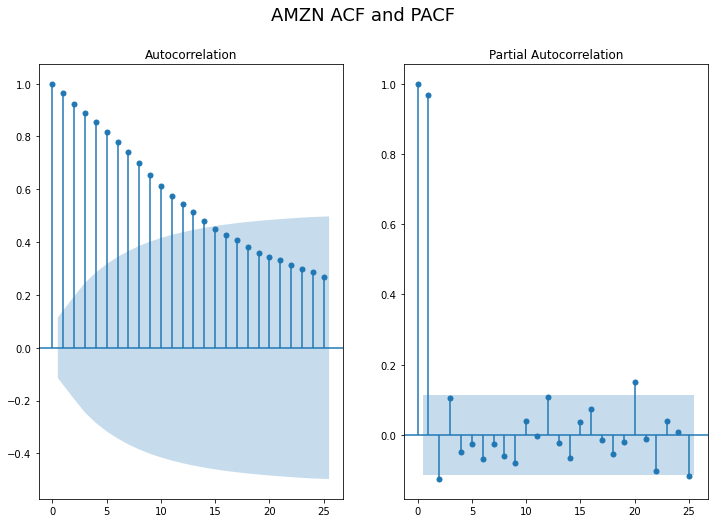

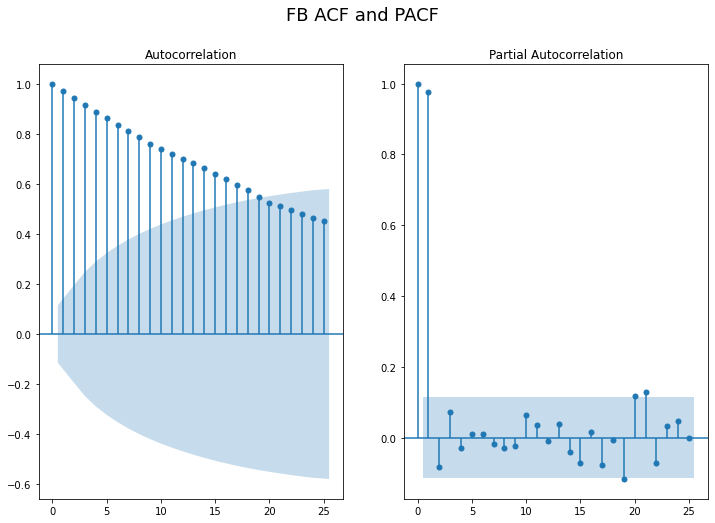

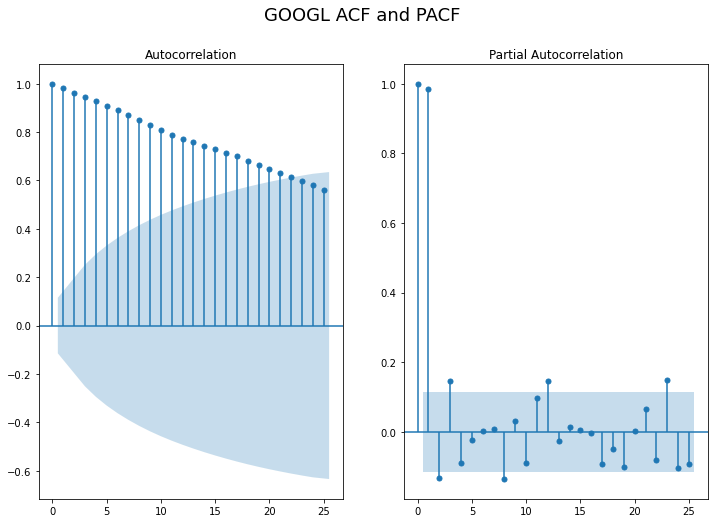

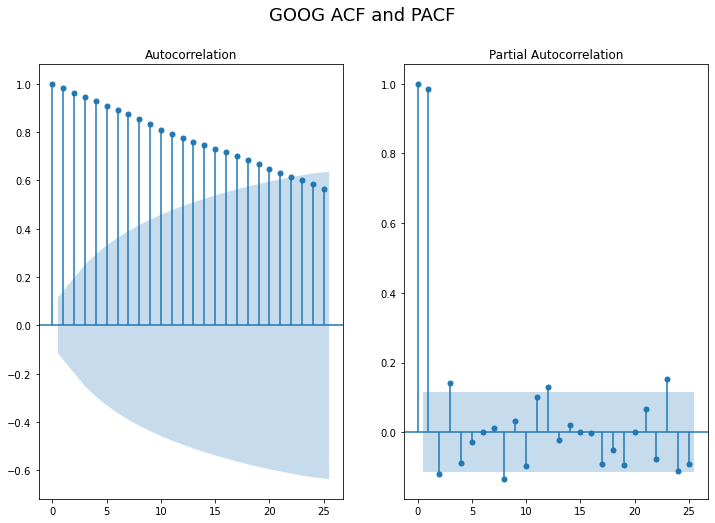

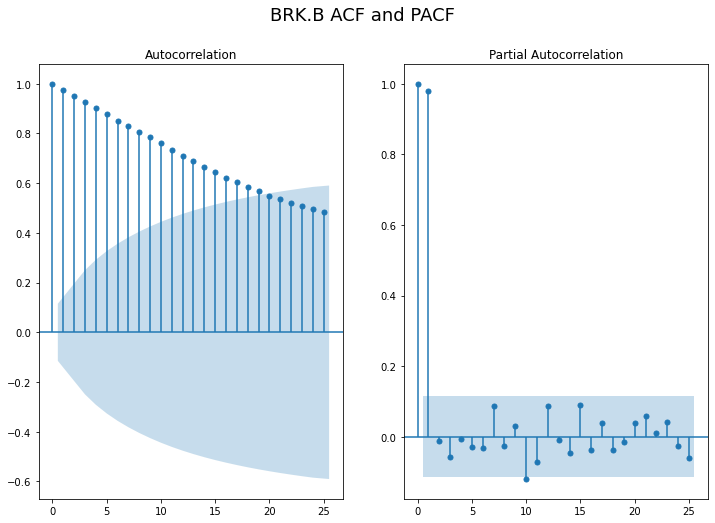

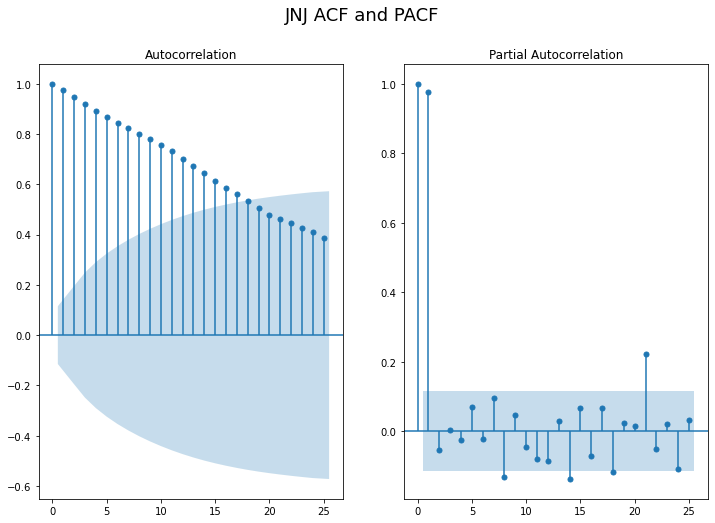

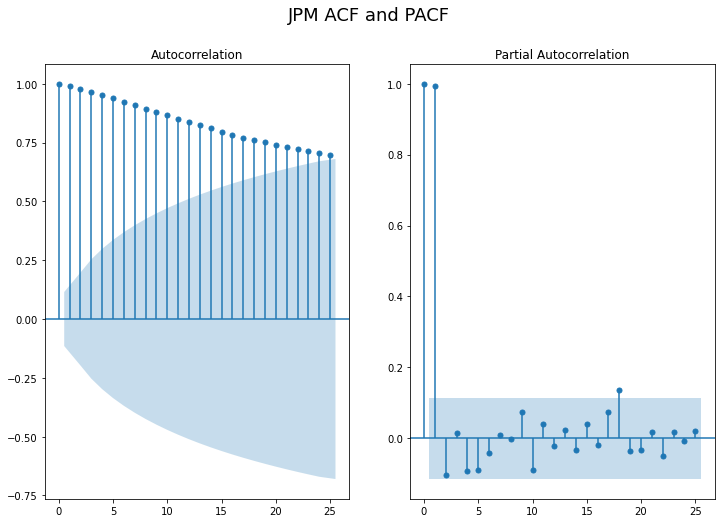

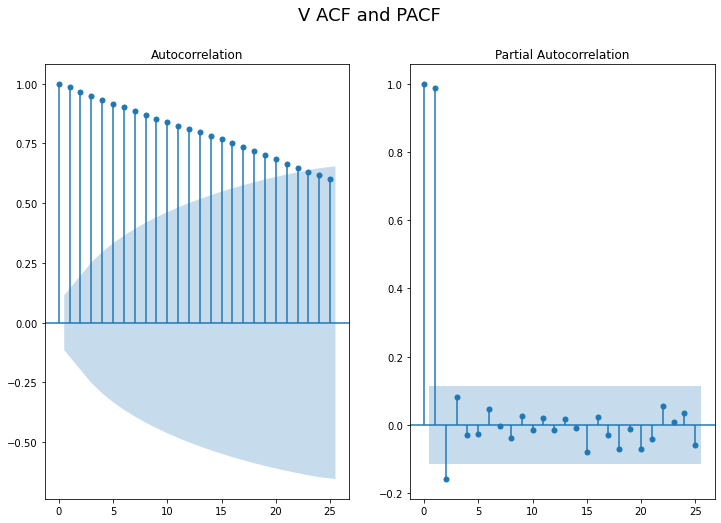

In [47]:
for symbol in symbols:
    filepath = "../data/{}_daily01.csv".format(symbol)
    stock_df = pd.read_csv(filepath)
    stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)]["close"]
    plot_title = "{} ACF and PACF".format(symbol)
    fig, ax = plt.subplots(1,2, figsize=(12,8))
    plot_acf(stock_df.values, ax=ax[0]);
    plot_pacf(stock_df.values, ax=ax[1]);
    fig.suptitle(plot_title, size=18)
    plt.savefig("../images/{}.acf_pacf.png".format(symbol))